# Load the raw data

In [66]:
import pandas as pd 
import os
import numpy as np
import plotly.graph_objects as go
import plotly
import plotly.express as px
import plotly.io as pio
from IPython.display import Image

# Load data
print('Beginning data loading ...')

# Data directory
dir_parent = os.path.dirname(os.getcwd())
dir_data = os.path.join(dir_parent, 'COVID-19/csse_covid_19_data/csse_covid_19_time_series')

# US case 
dir_US = os.path.join(dir_data, 'time_series_covid19_confirmed_us.csv')
US_case = pd.read_csv(dir_US)

# US death
dir_US_death = os.path.join(dir_data, 'time_series_covid19_deaths_US.csv')
US_death = pd.read_csv(dir_US_death)

# US state code
dir_US_state_abbreviation = os.path.join(os.getcwd(), 'data', 'US_state_abbreviation.csv')
US_state_abbreviation = pd.read_csv(dir_US_state_abbreviation)

print('Data loading finished!')


Beginning data loading ...
Data loading finished!


# Explore and analyze confirmed cases

## Clean up the data

In [67]:
# Drop unimportant columns
US_case.drop(columns=['UID', 'iso2', 'iso3','code3', 'Combined_Key', 'Country_Region'], inplace=True)

# Drop states associated with cruise ships
US_case.drop(US_case.index[US_case.Province_State.isin(['Diamond Princess', 'Grand Princess'])], inplace=True)

# Rename county column
US_case.rename(columns={'Admin2': 'County'}, inplace=True)

In [68]:
# Collapse across states
# We want to take the mean across lat and long columns
# and sum across the case columns.
dict_transform = {}
feature_column = US_case.keys()[3:]
for column in feature_column:
    if column in ['Lat', 'Long_']:
        dict_transform[column] = 'mean'
    else:
        dict_transform[column] = 'sum'
        
US_state_case = US_case.groupby('Province_State').agg(dict_transform).reset_index()

In [69]:
# Merge the state code table (for plotting chloropeth map)
US_state_case = US_state_abbreviation.merge(US_state_case, left_on='State', right_on='Province_State', how='outer')
US_state_case.drop(columns=['State'], inplace=True)

In [70]:
US_state_case.head(2)

Code Province_State        Lat       Long_  1/22/20  1/23/20  1/24/20  \
0   AL        Alabama  31.931113  -84.196785      0.0      0.0      0.0   
1   AK         Alaska  56.373544 -136.429656      0.0      0.0      0.0   

   1/25/20  1/26/20  1/27/20  ...  5/4/20  5/5/20  5/6/20  5/7/20  5/8/20  \
0      0.0      0.0      0.0  ...  8112.0  8437.0  8691.0  9046.0  9385.0   
1      0.0      0.0      0.0  ...   370.0   371.0   372.0   374.0   377.0   

   5/9/20  5/10/20  5/11/20  5/12/20  5/13/20  
0  9668.0   9889.0  10164.0  10464.0  10700.0  
1   378.0    379.0    379.0    383.0    383.0  

[2 rows x 117 columns]

## Look at top-15 states with the most number of cases

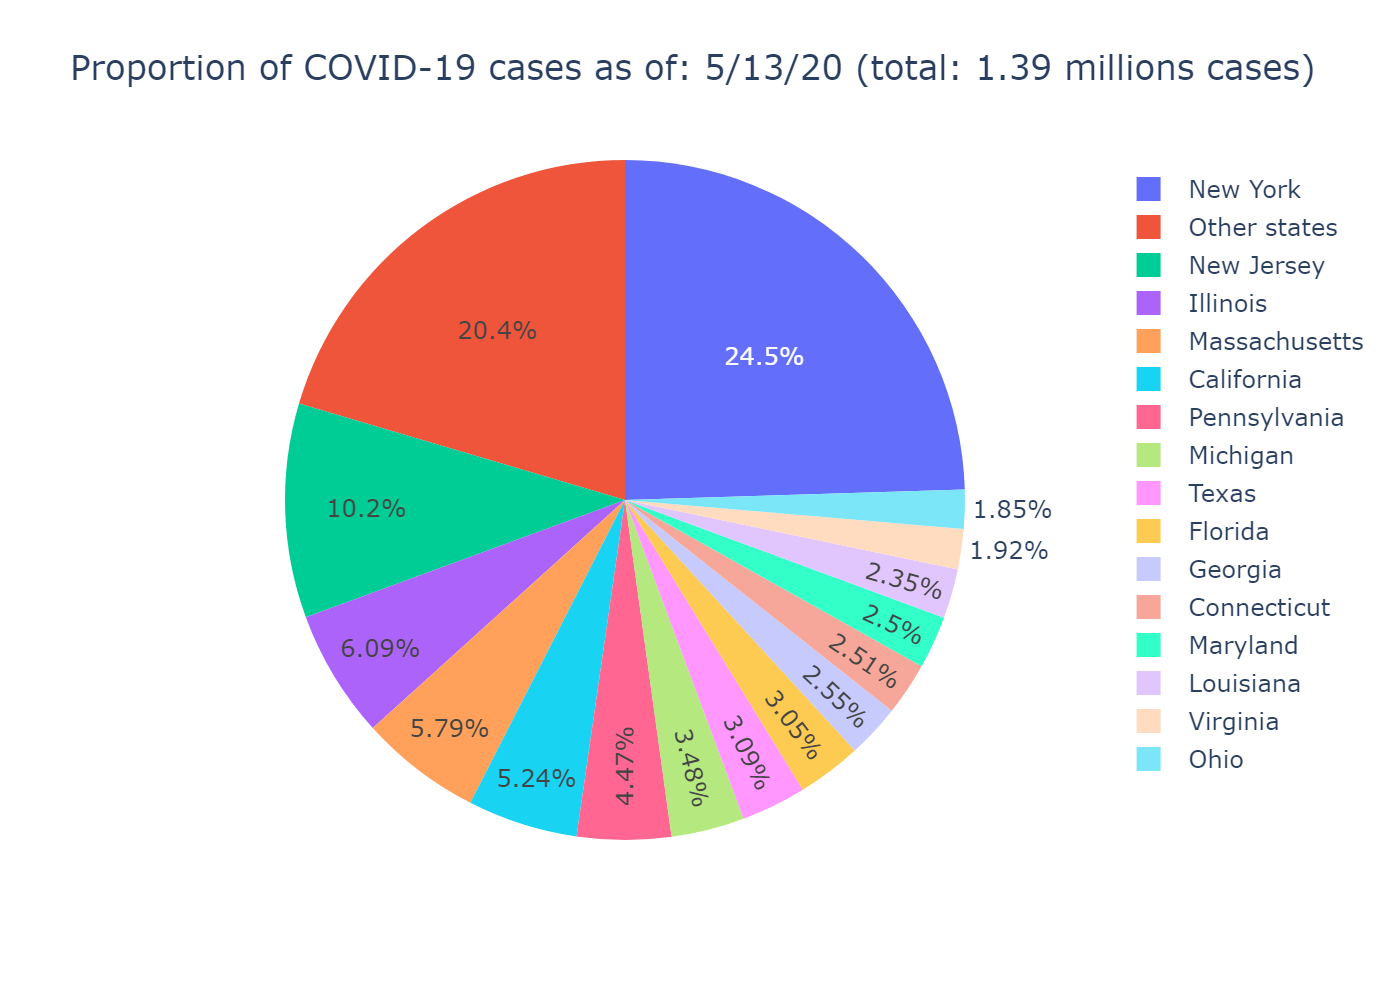

In [71]:
# Select top-15 states and aggregate all other countries
date_string = feature_column[2:]
total_case = round(US_state_case[date_string[-1]].sum() / 1000000, 2)
top_state = US_state_case.nlargest(15, date_string[-1])
state_collapse_bottom = US_state_case.copy()
state_collapse_bottom.loc[state_collapse_bottom[date_string[-1]] < top_state[date_string[-1]].min(),
                            'Province_State'] = 'Other states'


# Pie chart
fig = px.pie(state_collapse_bottom, values=date_string[-1], names='Province_State',
             title='Proportion of COVID-19 cases as of: ' + date_string[-1] + " (total: " + str(total_case) + " millions cases)")

margin_size = 80
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size))

# Interactive plot
# fig.show()

# Static plot (to show the figures on Github, I have to convert to static image)
# For interactive plot, use the interactive plot above
Image(pio.to_image(fig, format='png', scale=2))

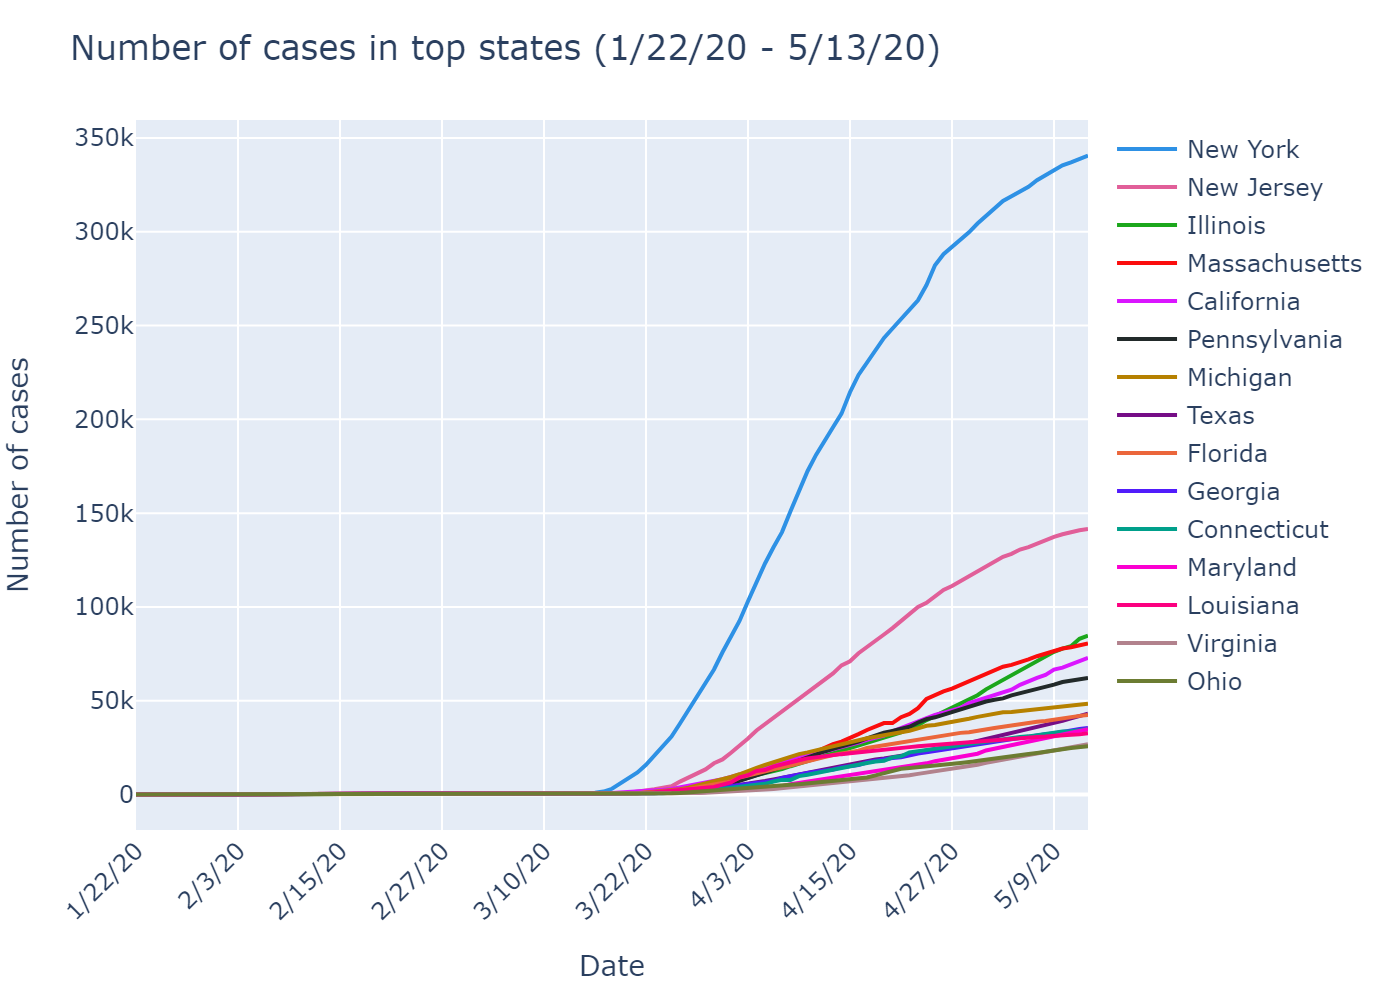

In [72]:
# Now let's look at the number of case across time
name_top_state = top_state['Province_State']
matrix_num_case = top_state.drop(columns=['Code', 'Province_State', 'Lat', 'Long_']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in top states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

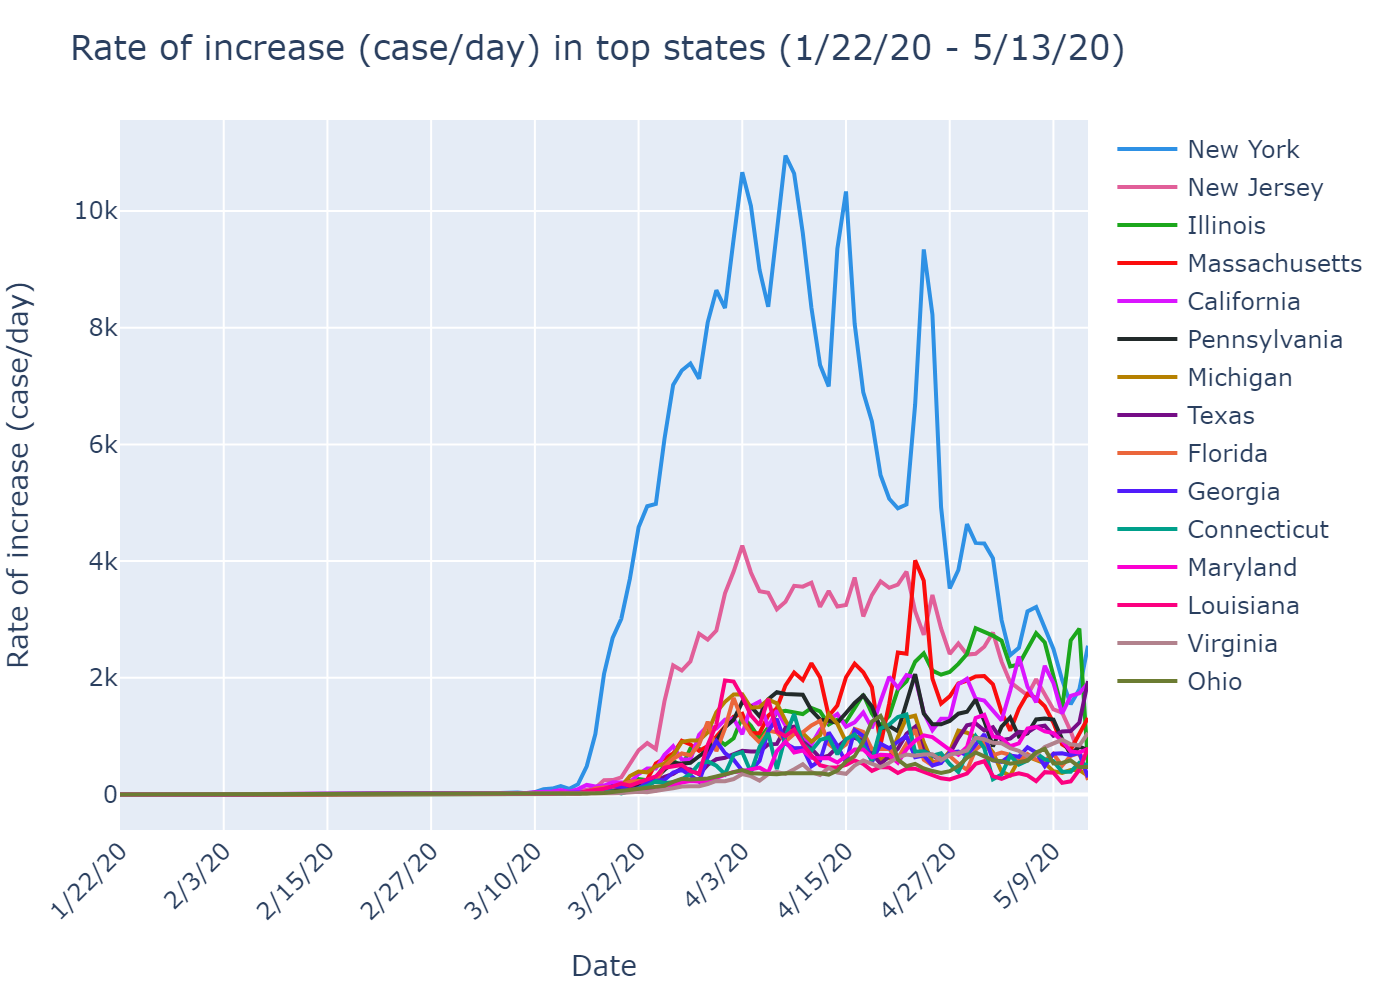

In [73]:
# Now let's look at the rate of increase
name_top_state = top_state['Province_State']
matrix_num_case_gradient = np.gradient(matrix_num_case, axis=1, edge_order =2)

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case_gradient[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Rate of increase (case/day) in top states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Rate of increase (case/day)',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

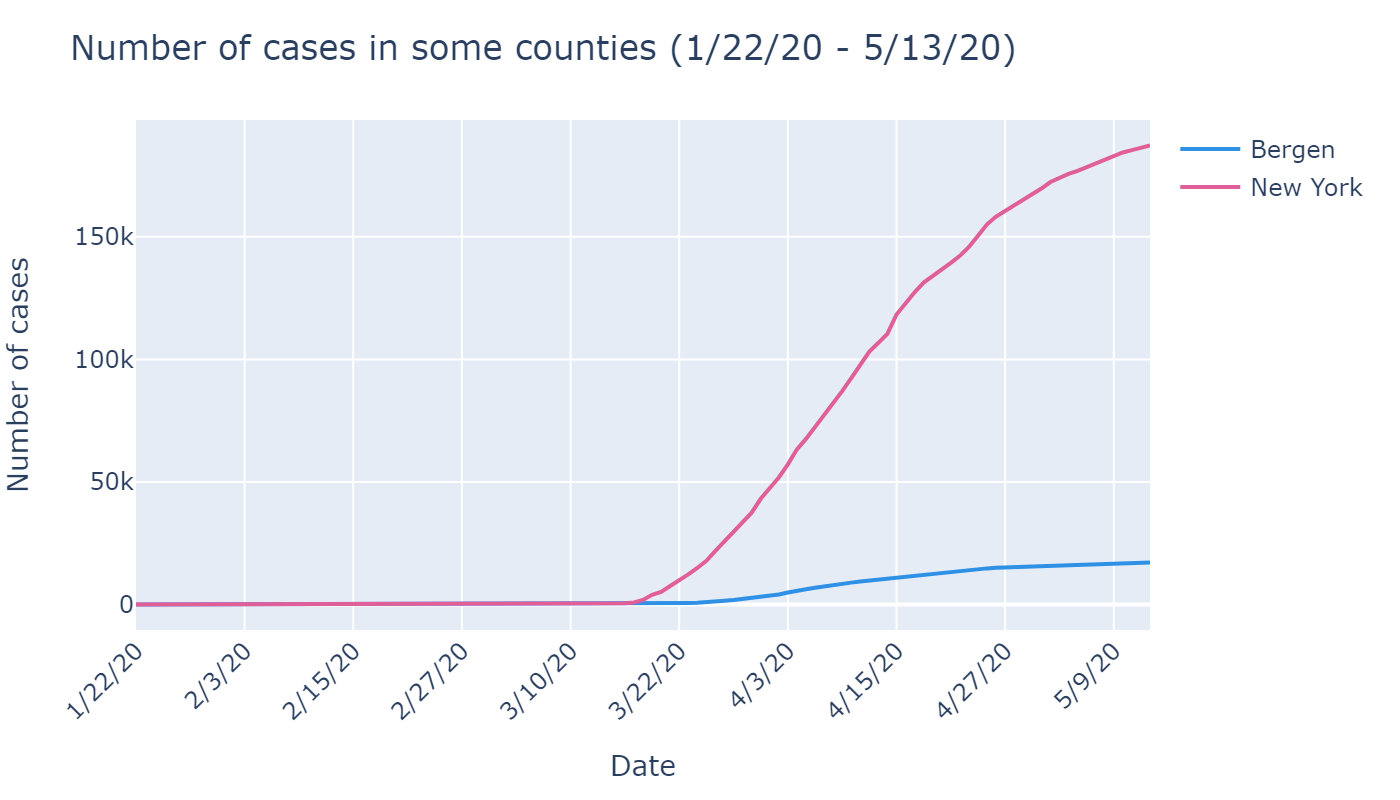

In [74]:
# Look at some cities I'm interested in
county_interest = US_case[US_case.County.isin(['New York', 'Bergen']) 
                          & US_case.Province_State.isin(['New York', 'New Jersey'])]
county_interest_name = county_interest['County']

# Now let's look at the number of case across time
matrix_num_case = county_interest.drop(columns=['FIPS', 'County', 'Province_State', 'Lat', 'Long_']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(county_interest_name):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in some counties (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=400)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Look at bottom-15 states with the least number of cases

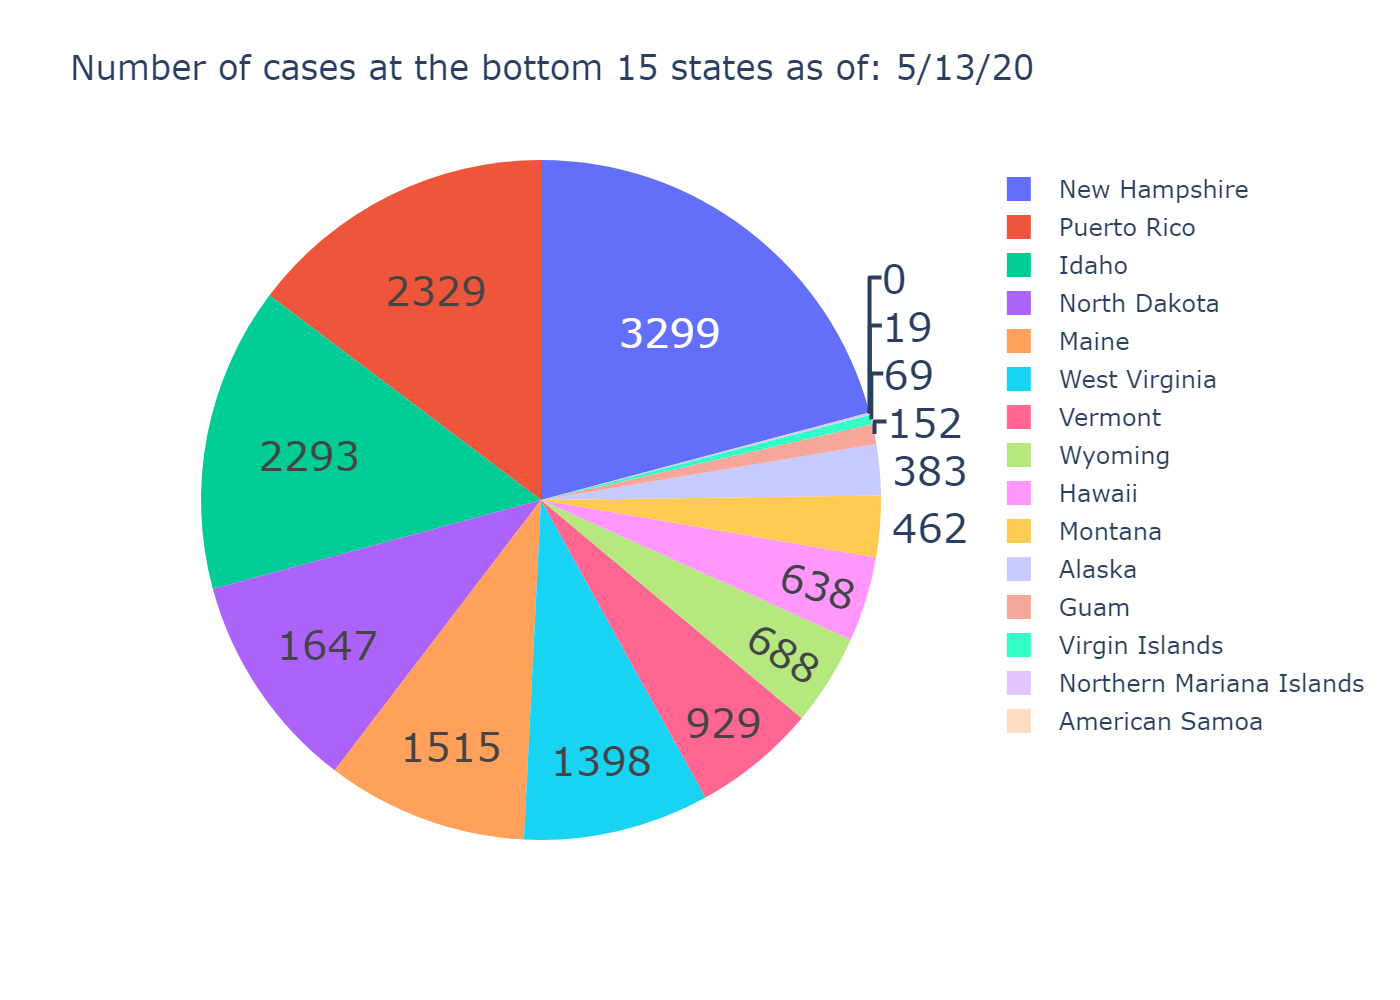

In [75]:
# Display the states with the least number of cases
bottom_state = US_state_case.nsmallest(15, date_string[-1])

fig = go.Figure(data=[go.Pie(labels=bottom_state['Province_State'],
                             values=bottom_state[date_string[-1]])])

margin_size = 80
fig.update_traces(hoverinfo='label+value', textinfo='value', textfont_size=20)
fig.update_layout(margin=dict(l=margin_size-20, r=margin_size-20, t=margin_size, b=margin_size),
                 title_text='Number of cases at the bottom 15 states as of: ' + date_string[-1])

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

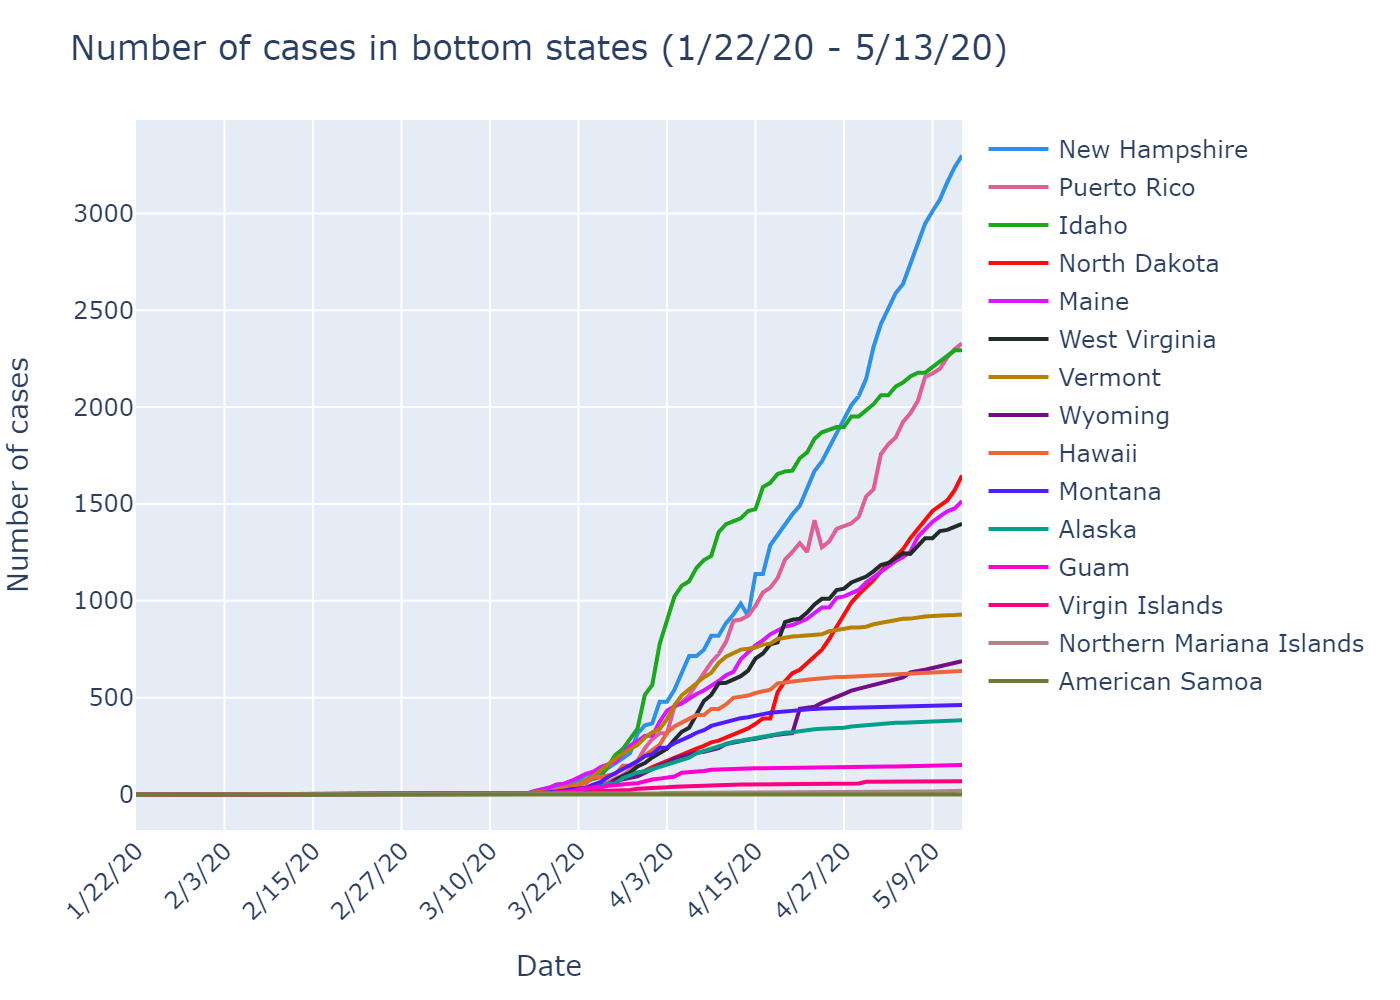

In [76]:
# Now let's look at the number of case across time
bottom_state.sort_values(by=[date_string[-1]], ascending=False, inplace=True)
name_bottom_state = bottom_state['Province_State']
matrix_num_case = bottom_state.drop(columns=['Code', 'Province_State', 'Lat', 'Long_']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_bottom_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in bottom states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

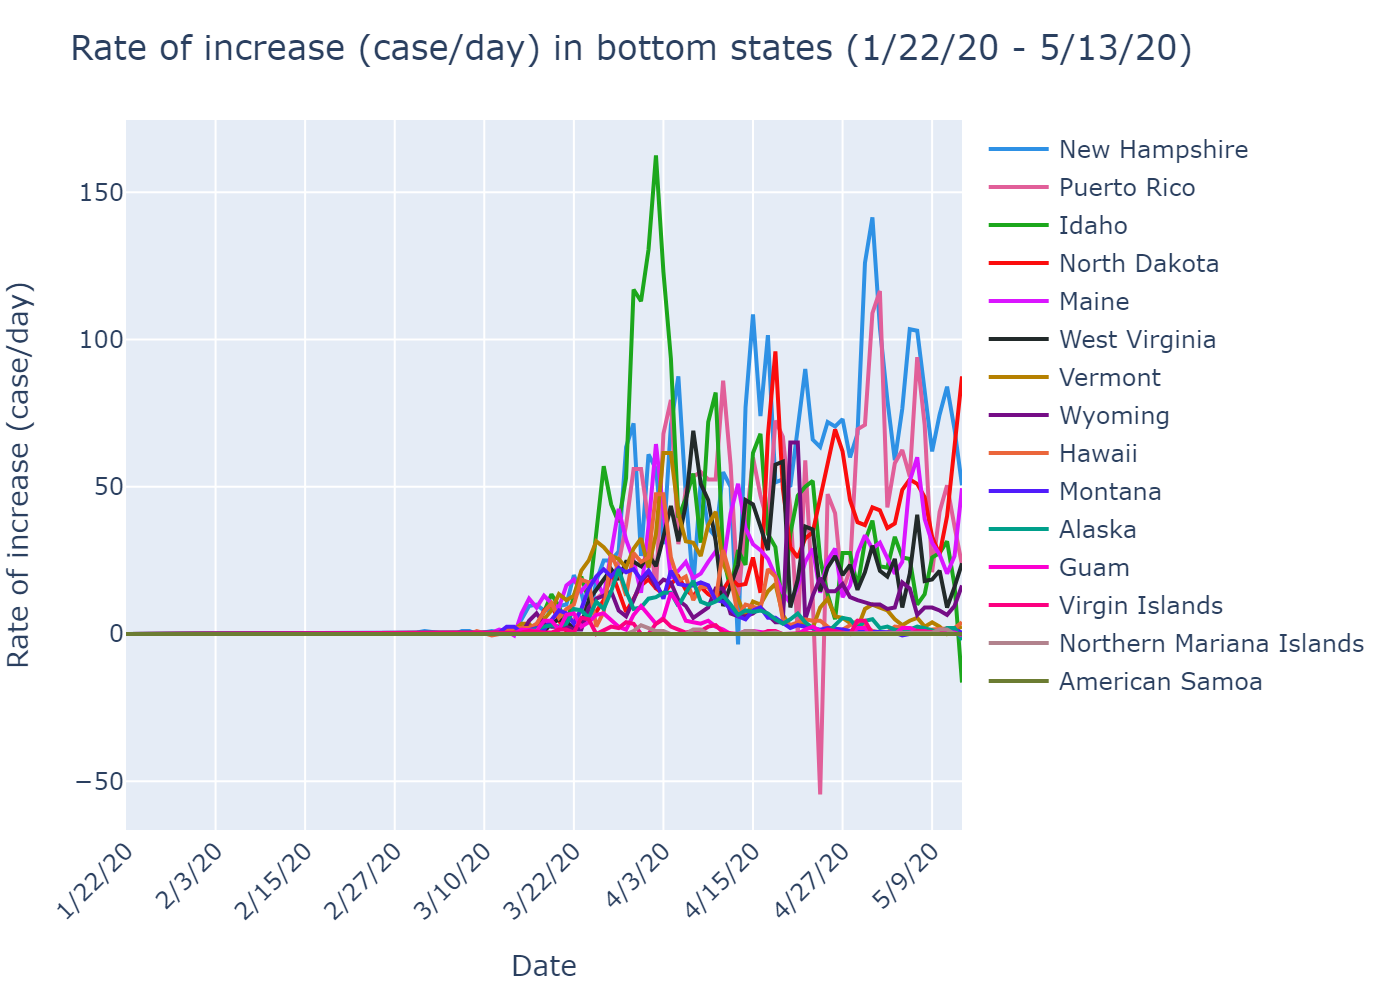

In [77]:
# Now let's look at the rate of increase
matrix_num_case_gradient = np.gradient(matrix_num_case, axis=1, edge_order =2)

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_bottom_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case_gradient[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Rate of increase (case/day) in bottom states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Rate of increase (case/day)',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## See the cases on map

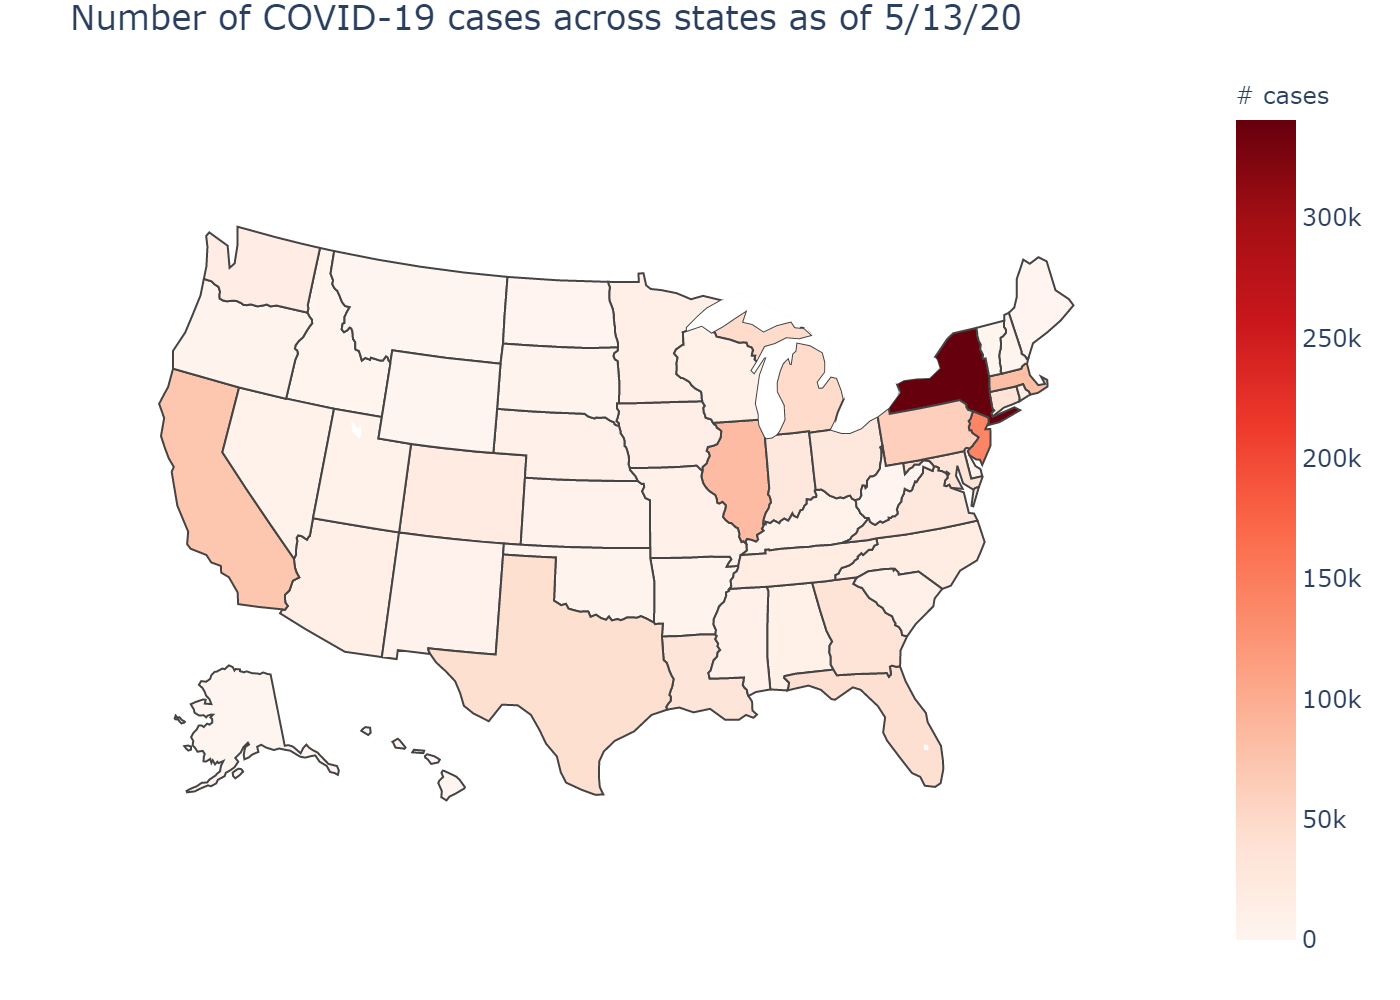

In [78]:
# Plot all states
fig = go.Figure(data=go.Choropleth(
    locations=US_state_case["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state_case[date_string[-1]].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# cases",
    text=US_state_case["Province_State"]    
))

fig.update_layout(
    title_text = 'Number of COVID-19 cases across states as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

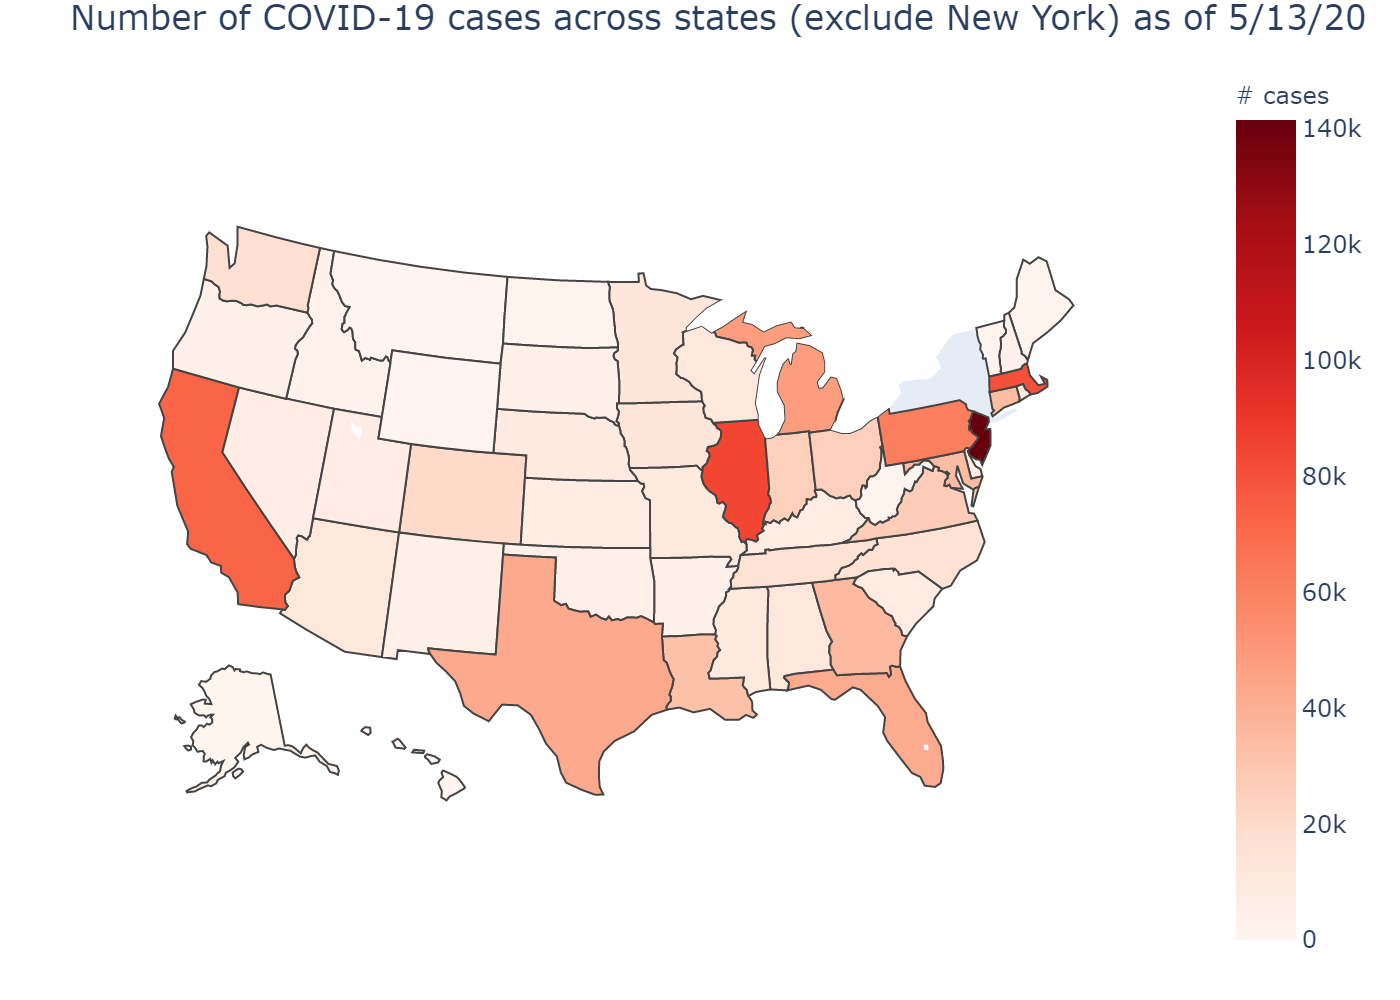

In [79]:
# Exclude NY
US_state_case_dropNY = US_state_case[US_state_case['Province_State'] != 'New York']
fig = go.Figure(data=go.Choropleth(
    locations=US_state_case_dropNY["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state_case_dropNY[date_string[-1]].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# cases",
    text=US_state_case_dropNY["Province_State"]
))

fig.update_layout(
    title_text = 'Number of COVID-19 cases across states (exclude New York) as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

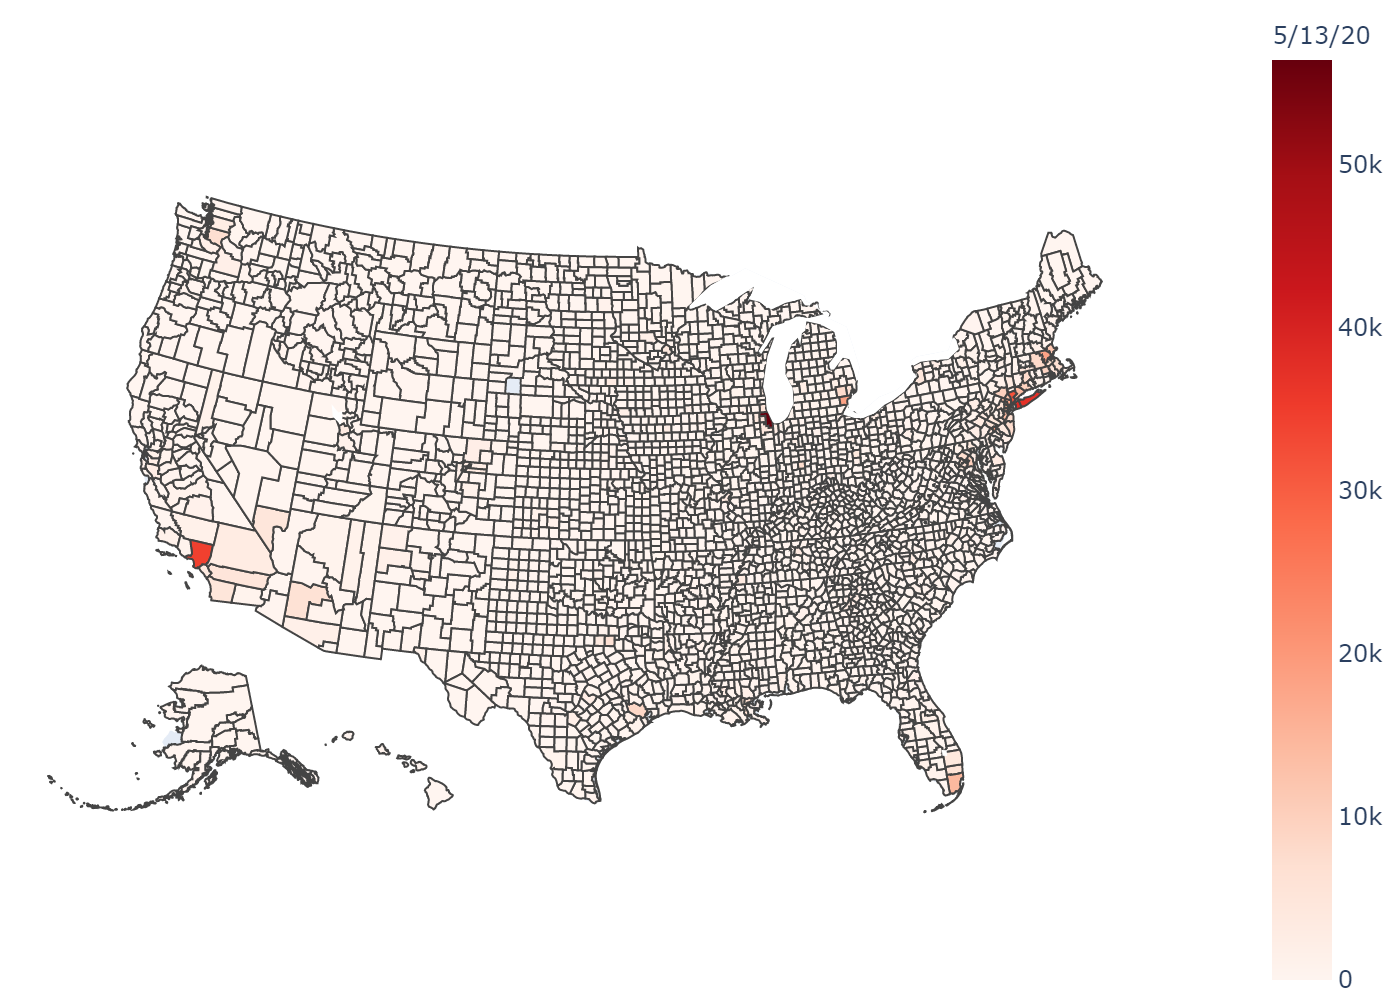

In [80]:
# Convert FIPS to appropriate format For plotting
fips_mat = US_case.loc[US_case.FIPS.notnull(), 'FIPS'].values
fips_mat = list(fips_mat.astype('int32').astype(str))
for index, fips in enumerate(fips_mat):
    if len(fips) == 2:
        fips_mat[index] = '000' + fips_mat[index]
    elif len(fips) == 3:
        fips_mat[index] = '00' + fips_mat[index]
    elif len(fips) == 4:
        fips_mat[index] = '0' + fips_mat[index]
        
US_case.loc[US_case.FIPS.notnull(), 'FIPS'] = fips_mat

# Plot the county map      
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
    
# Map without New York city
US_case_dropNY = US_case[US_case['County'] != 'New York']
fig = px.choropleth(US_case_dropNY, geojson=counties, locations='FIPS', color=date_string[-1],
                    color_continuous_scale="Reds", hover_name='County', scope="usa")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

### It seems like most cases are localized to small regions (esp. the busy areas).

# Explore and analyze deaths

## Clean up the data

In [81]:
# Drop unimportant columns
US_death.drop(columns=['UID', 'iso2', 'iso3','code3', 'Combined_Key', 'Country_Region'], inplace=True)

# Drop states associated with cruise ships
US_death.drop(US_death.index[US_death.Province_State.isin(['Diamond Princess', 'Grand Princess'])], inplace=True)

# Rename county column
US_death.rename(columns={'Admin2': 'County'}, inplace=True)

In [82]:
US_death.iloc[:5, :10]

FIPS County            Province_State      Lat     Long_  Population  \
0  60.0    NaN            American Samoa -14.2710 -170.1320       55641   
1  66.0    NaN                      Guam  13.4443  144.7937      164229   
2  69.0    NaN  Northern Mariana Islands  15.0979  145.6739       55144   
3  72.0    NaN               Puerto Rico  18.2208  -66.5901     2933408   
4  78.0    NaN            Virgin Islands  18.3358  -64.8963      107268   

   1/22/20  1/23/20  1/24/20  1/25/20  
0        0        0        0        0  
1        0        0        0        0  
2        0        0        0        0  
3        0        0        0        0  
4        0        0        0        0

In [83]:
# Collapse across states
# We want to take the mean across 'Lat' and 'Long_' columns
# and sum across the case and 'Population' columns.
dict_transform = {}
feature_column = US_death.keys()[3:]
for column in feature_column:
    if column in ['Lat', 'Long_']:
        dict_transform[column] = 'mean'
    elif column == 'Population':
        dict_transform[column] = 'sum'
    else:
        dict_transform[column] = 'sum'
        
US_death_state = US_death.groupby('Province_State').agg(dict_transform).reset_index()

In [84]:
# Merge the state code table (for plotting chloropeth map)
US_death_state = US_state_abbreviation.merge(US_death_state, left_on='State', right_on='Province_State', how='outer')
US_death_state.drop(columns=['State'], inplace=True)

In [85]:
US_death_state.head(2)

Code Province_State        Lat       Long_  Population  1/22/20  1/23/20  \
0   AL        Alabama  31.931113  -84.196785   4903185.0      0.0      0.0   
1   AK         Alaska  56.373544 -136.429656    731545.0      0.0      0.0   

   1/24/20  1/25/20  1/26/20  ...  5/4/20  5/5/20  5/6/20  5/7/20  5/8/20  \
0      0.0      0.0      0.0  ...   298.0   315.0   343.0   369.0   383.0   
1      0.0      0.0      0.0  ...     9.0     9.0    10.0    10.0    10.0   

   5/9/20  5/10/20  5/11/20  5/12/20  5/13/20  
0   390.0    393.0    403.0    435.0    450.0  
1    10.0     10.0     10.0     10.0     10.0  

[2 rows x 118 columns]

## Look at top-15 states with the most number of deaths

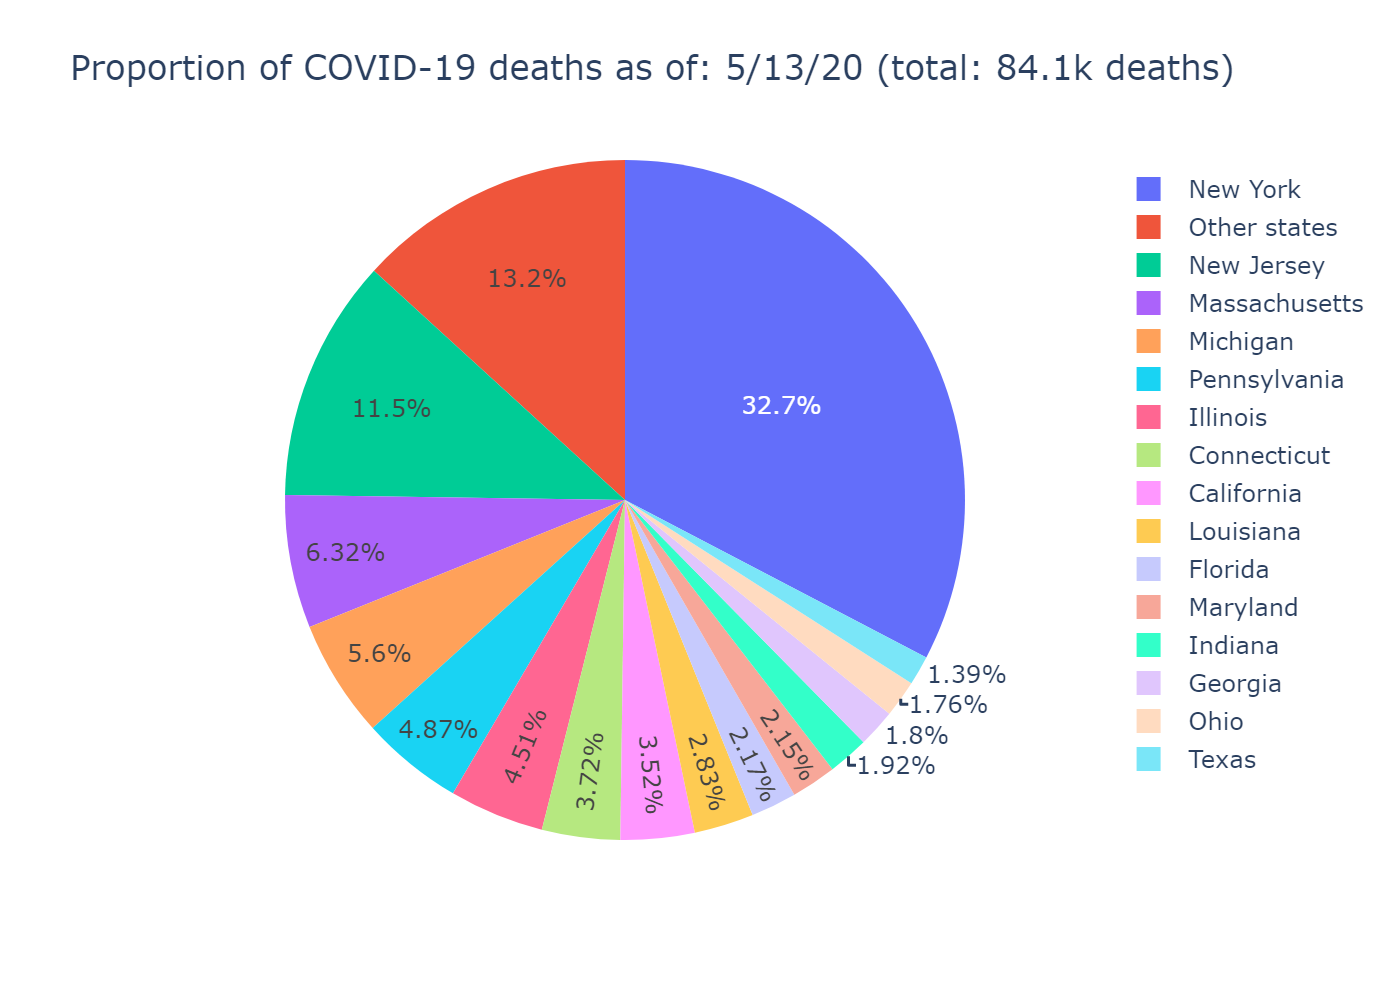

In [86]:
# Select top-15 states and aggregate all other countries
total_case = round(US_death_state[date_string[-1]].sum() / 1000, 1)
top_state = US_death_state.nlargest(15, date_string[-1])
state_collapse_bottom = US_death_state.copy()
state_collapse_bottom.loc[state_collapse_bottom[date_string[-1]] < top_state[date_string[-1]].min(),
                            'Province_State'] = 'Other states'


# Pie chart
fig = px.pie(state_collapse_bottom, values=date_string[-1], names='Province_State',
             title='Proportion of COVID-19 deaths as of: ' + date_string[-1] + " (total: " + str(total_case) + "k deaths)")

margin_size = 80
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size))

# Interactive plot
# fig.show()

# Static plot (to show the figures on Github, I have to convert to static image)
# For interactive plot, use the interactive plot above
Image(pio.to_image(fig, format='png', scale=2))

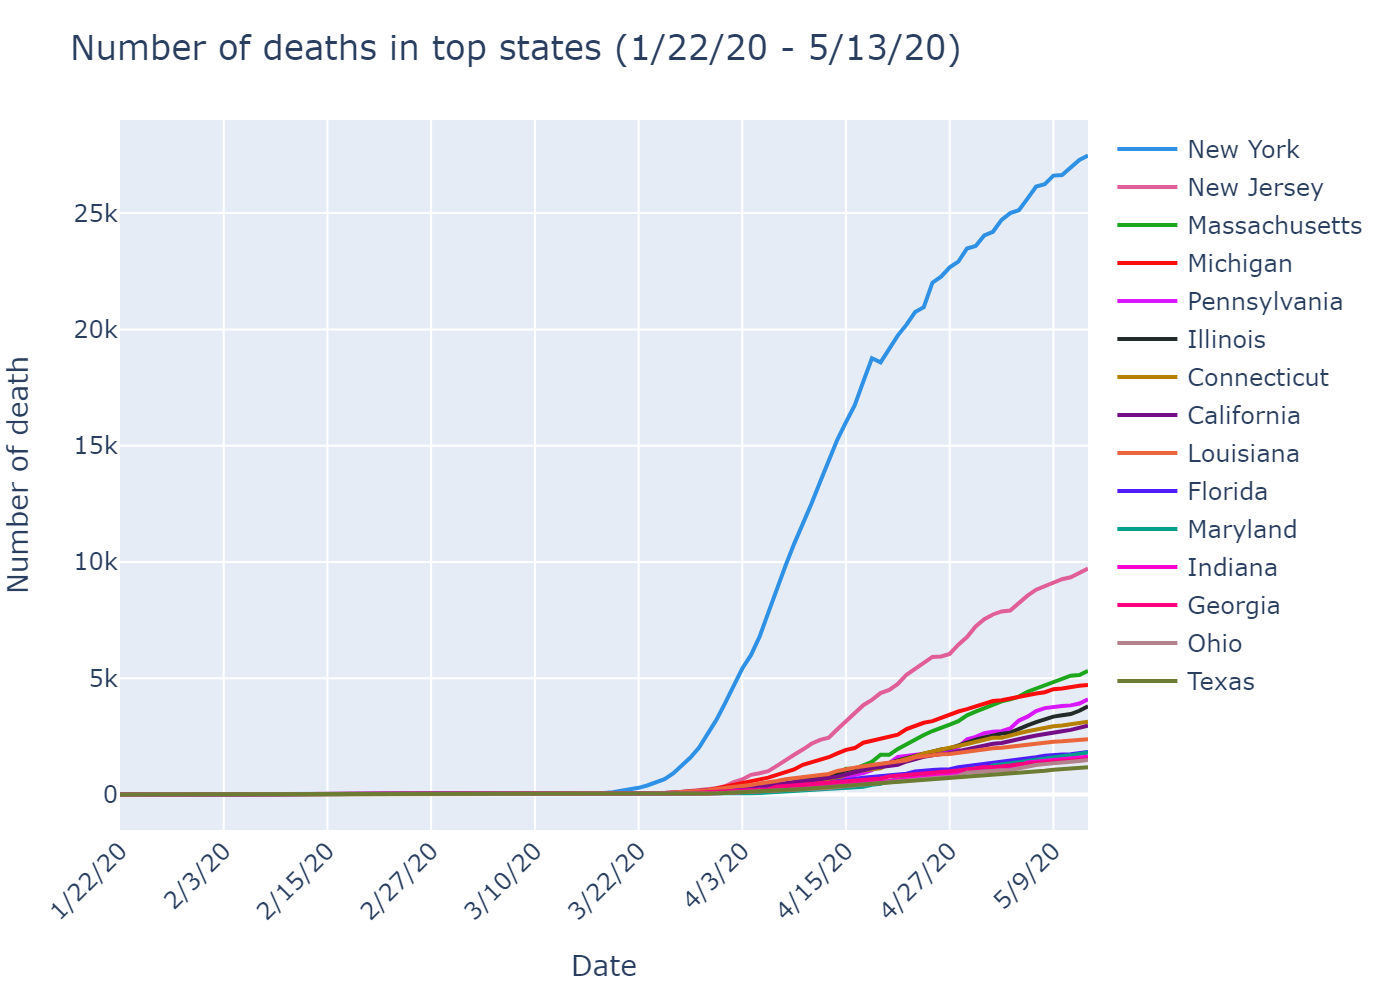

In [87]:
# Now let's look at the number of death across time
name_top_state = top_state['Province_State']
matrix_num_case = top_state.drop(columns=['Code', 'Province_State', 'Lat', 'Long_', 'Population']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of deaths in top states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of death',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

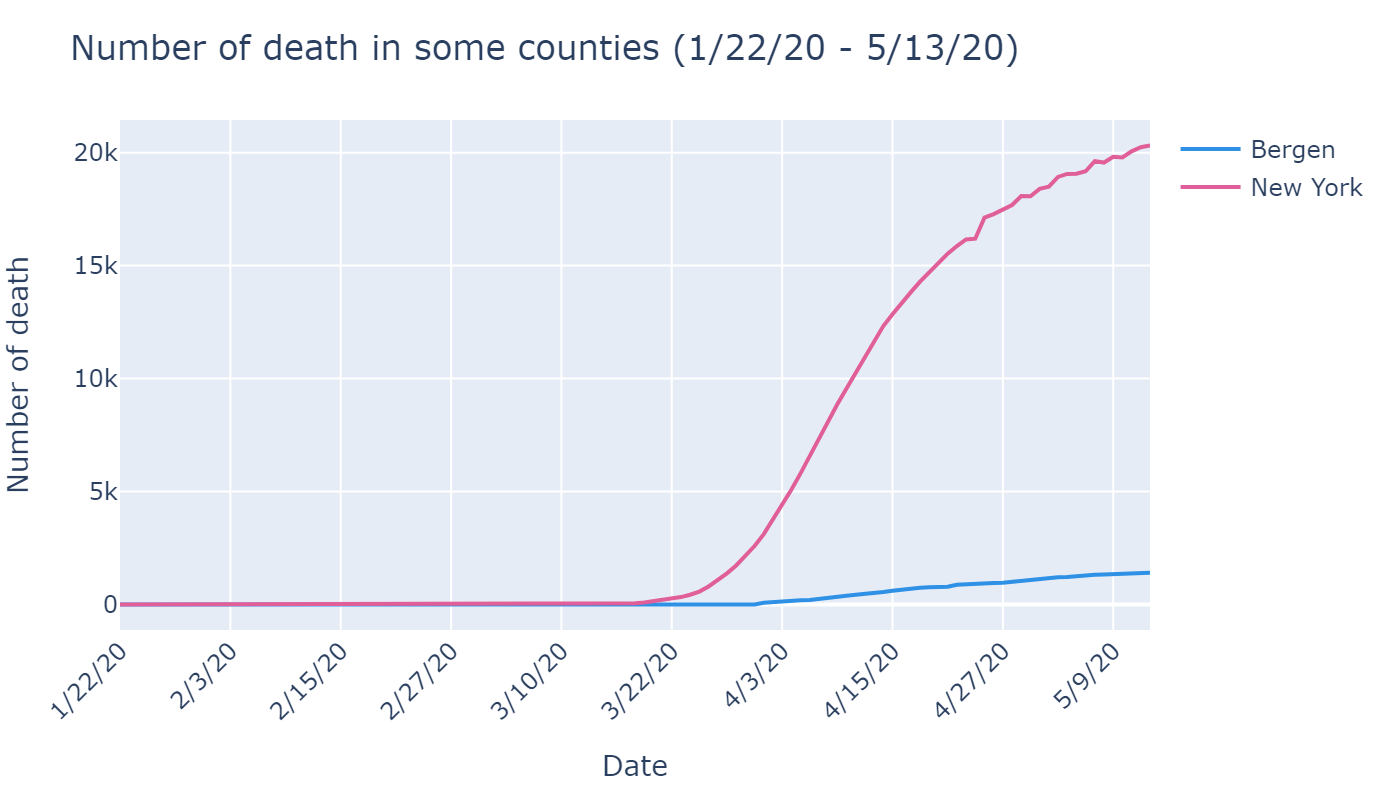

In [88]:
# Look at some cities I'm interested in
county_interest = US_death[US_death.County.isin(['New York', 'Bergen']) 
                          & US_death.Province_State.isin(['New York', 'New Jersey'])]
county_interest_name = county_interest['County']

# Now let's look at the number of case across time
matrix_num_case = county_interest.drop(columns=['FIPS', 'County', 'Province_State', 'Lat', 'Long_', 'Population']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(county_interest_name):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of death in some counties (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of death',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=400)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Look at bottom-15 states with the least number of death

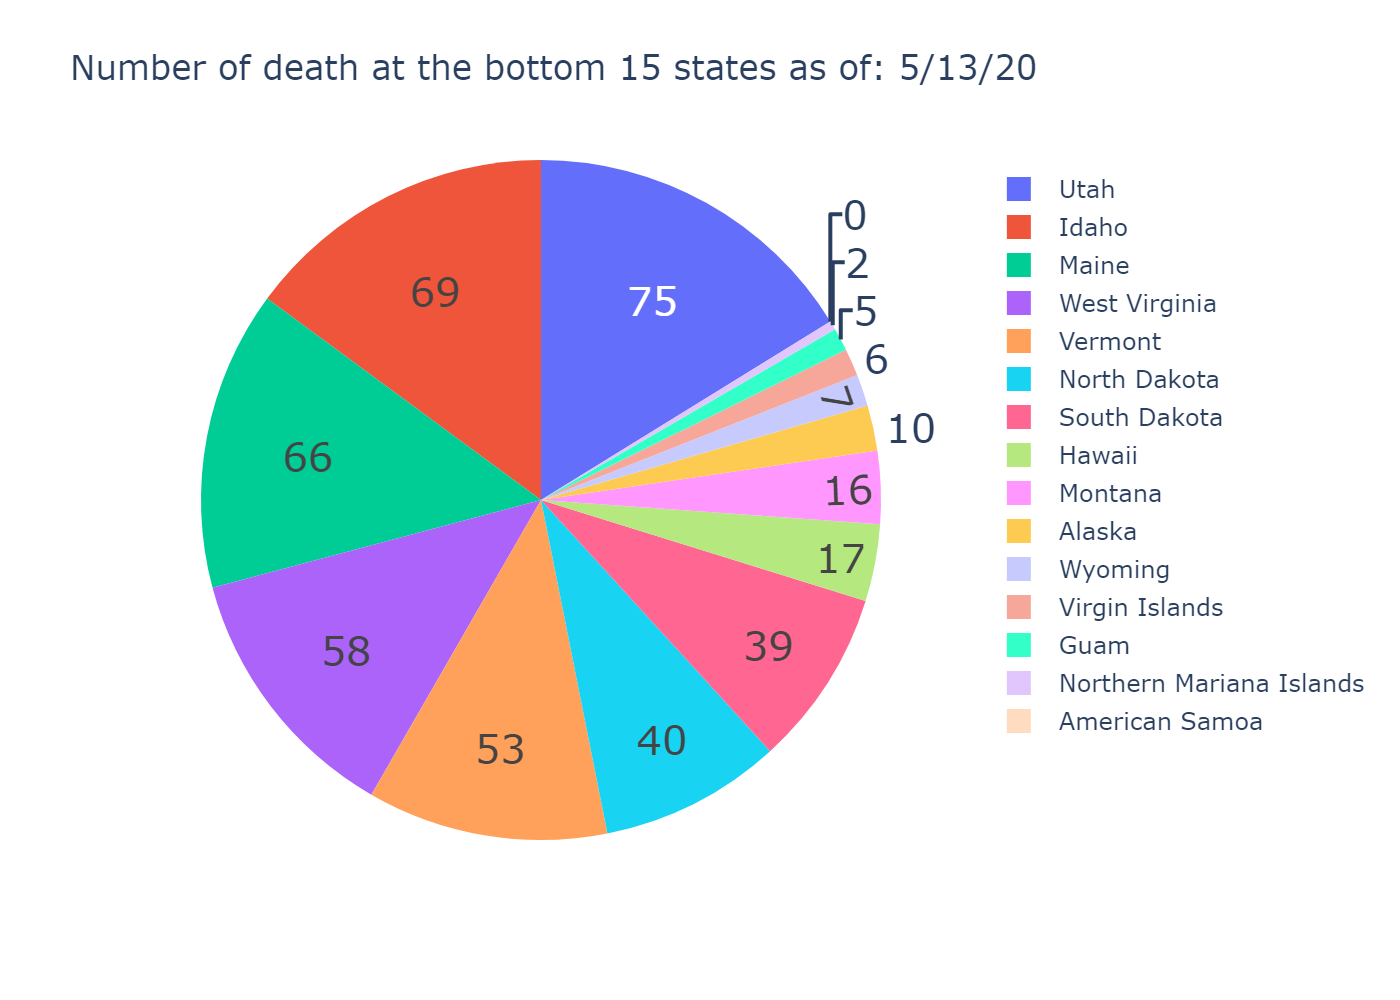

In [90]:
# Display the states with the least number of cases
bottom_state = US_death_state.nsmallest(15, date_string[-1])

fig = go.Figure(data=[go.Pie(labels=bottom_state['Province_State'],
                             values=bottom_state[date_string[-1]])])

margin_size = 80
fig.update_traces(hoverinfo='label+value', textinfo='value', textfont_size=20)
fig.update_layout(margin=dict(l=margin_size-20, r=margin_size-20, t=margin_size, b=margin_size),
                 title_text='Number of death at the bottom 15 states as of: ' + date_string[-1])

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

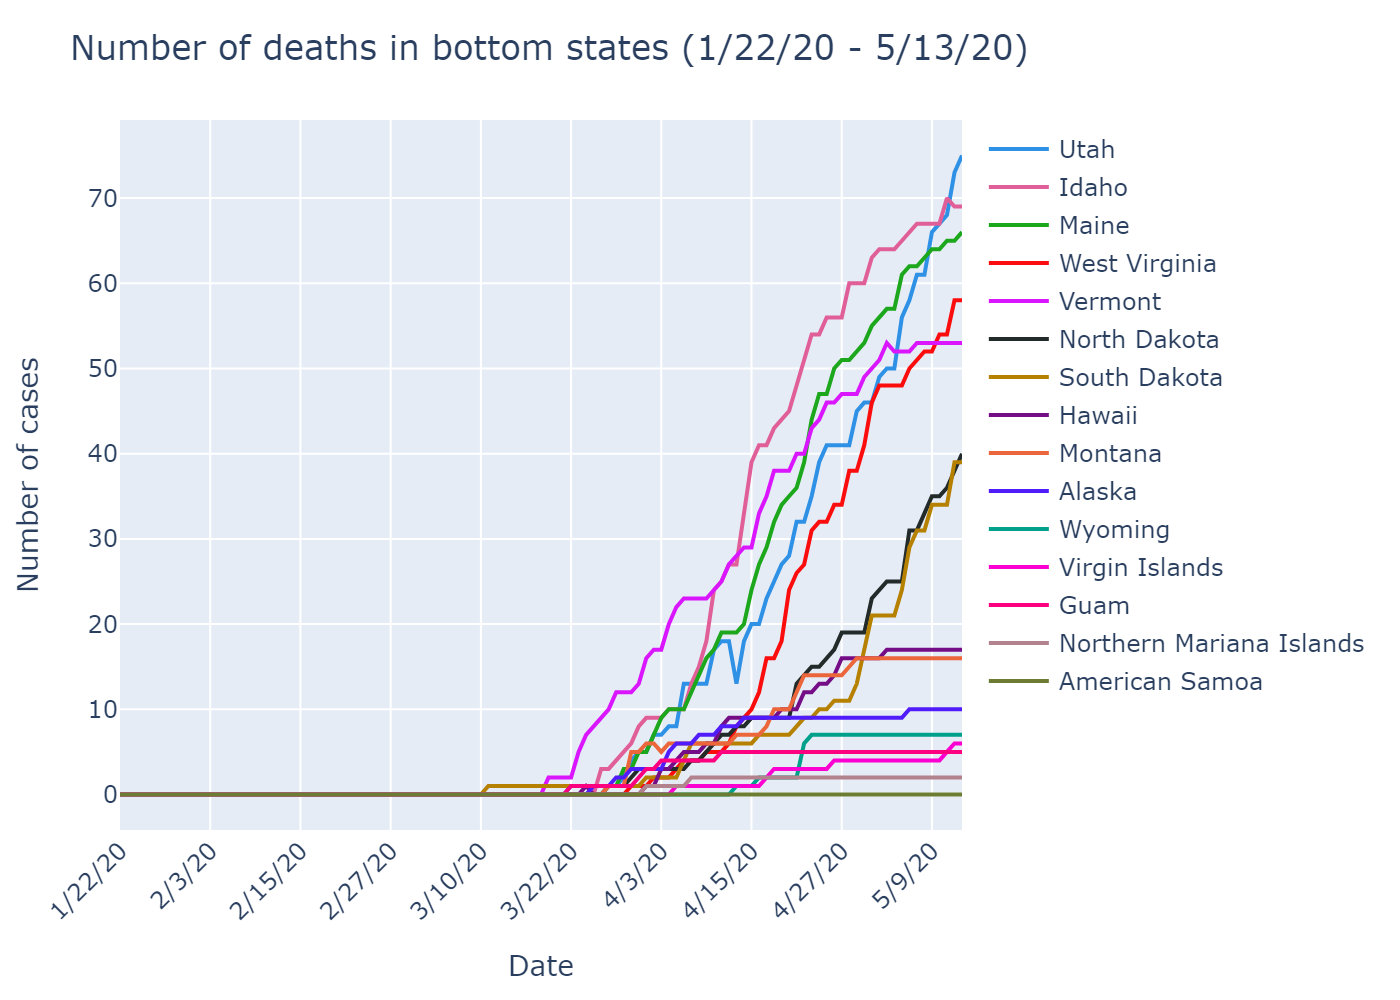

In [91]:
# Now let's look at the number of case across time
bottom_state.sort_values(by=[date_string[-1]], ascending=False, inplace=True)
name_bottom_state = bottom_state['Province_State']
matrix_num_case = bottom_state.drop(columns=['Code', 'Province_State', 'Lat', 'Long_', 'Population']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_bottom_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of deaths in bottom states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## See the number of deaths on map